In [1]:
import pandas as pd
import fastai.text as ftxt
import sklearn.model_selection as skms
import numpy as np
import spacy as sp
import pickle
import os

In [2]:
#import torch

In [3]:
#torch.cuda.is_available()

In [4]:
#torch.__version__

In [2]:
path = os.getcwd()
path

'/media/rinnely/Archer/ENES/Stance/legal_abortion'

In [3]:
path = os.getcwd()
topic = 'la'
os.makedirs(path+'/NN/'+ topic, exist_ok=True)
path_nn_model= path+'/NN/'+topic
path_nn_model

'/media/rinnely/Archer/ENES/Stance/legal_abortion/NN/la'

In [18]:
tweets = pd.read_csv(path+'/alldatala.csv')

In [19]:
tweets.head()

,Unnamed: 0,Tweet,Stance
0,0,Just laid down the law on abortion in my bioet...,-1
1,1,@tooprettyclub Are you OK with #GOP males tell...,1
2,2,"If you don't want your kid, put it up for adop...",-1
3,3,"@RedAlert -there should be a ""stigma"" to butch...",-1
4,4,But isn't that the problem then. Not enough fa...,0


In [23]:
tweets = tweets[['Stance', 'Tweet']][900:]

In [20]:
original = tweets[['Stance', 'Tweet']][:900]

In [21]:
tweets.head()

,Unnamed: 0,Tweet,Stance
0,0,Just laid down the law on abortion in my bioet...,-1
1,1,@tooprettyclub Are you OK with #GOP males tell...,1
2,2,"If you don't want your kid, put it up for adop...",-1
3,3,"@RedAlert -there should be a ""stigma"" to butch...",-1
4,4,But isn't that the problem then. Not enough fa...,0


In [22]:
original.shape

(900, 2)

In [24]:
tweets.shape

(3122, 2)

In [12]:
tweets['Stance']=tweets.Stance.replace({'FAVOR':1, 'AGAINST':-1, 'NONE':0})

TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

In [31]:
train, test = skms.train_test_split(tweets, test_size=.82)

In [32]:
train.shape, test.shape

((561, 2), (2561, 2))

In [33]:
train = train.append(original)

In [34]:
train, test = skms.train_test_split(train, test_size=.30)

In [35]:
train.shape, test.shape

((1022, 2), (439, 2))

In [36]:
train.to_csv(path_nn_model+'/train_tweets150070.csv', index=False)
test.to_csv(path_nn_model+'/test_tweets150030.csv', index=False)

In [37]:
train = pd.read_csv(path_nn_model+'/train_tweets150070.csv')
test = pd.read_csv(path_nn_model+'/test_tweets150030.csv')

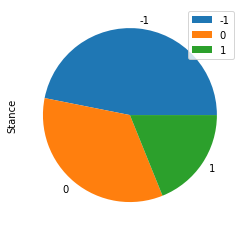

In [38]:
train['Stance'].value_counts().plot.pie(legend=True)

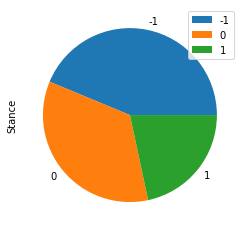

In [39]:
test['Stance'].value_counts().plot.pie(legend=True)

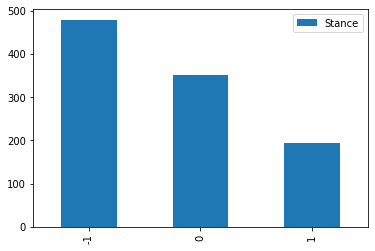

In [40]:
train['Stance'].value_counts().plot.bar(legend=True)

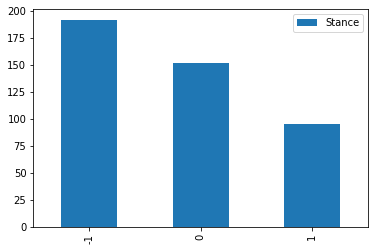

In [41]:
test['Stance'].value_counts().plot.bar(legend=True)

In [42]:
train

,Stance,Tweet
0,-1,@abelitomiranda ...about the millions of abort...
1,-1,#NothingMoreAmericanThan unjustified homicide ...
2,1,famous football-playing rapist jameis winston ...
3,-1,@ghhshirley Charged with Manslaughter After An...
4,-1,@benjaminswatson at #marchforlife: 'you can ch...
...,...,...
1017,-1,"in the media - @mailonline: ""mother with disab..."
1018,0,Another SCOTUS decision I do not agree with. I...
1019,-1,our #trainspottinglive tour is in full swing s...
1020,-1,"mt @amenditusa: new mood,new plan. let america..."


In [43]:
data_lm = ftxt.TextLMDataBunch.from_df(path_nn_model, train, test, bs=32)
data_clas = ftxt.TextClasDataBunch.from_df(path_nn_model, train, test, vocab=data_lm.train_ds.vocab, bs=32)

In [44]:
data_lm.show_batch()

idx,text
0,"of generations ' xxunk xxbos i would never expect an 11 year old girl to have to carry a pregnancy to term xxbos xxunk court xxunk get more xxunk as they get xxunk "" article here = = > xxbos just in : # scotus xxunk stay of execution for xxunk xxunk , set to be xxunk by texas tonight . xxbos xxmaj hey , # bristolpalin , when xxmaj"
1,"would you want to make people have kids ? xxmaj xxunk when they 're not xxunk ? xxmaj makes no sense . xxbos i love this so much # loveislove # lovewins # loveislove # lovewins # loveislove # lovewins xxunk xxunk xxbos wonderful to see xxunk students at dc 's march for life . we are the xxbos xxmaj just like abortion , even though xxup scotus says gay"
2,". xxbos xxmaj xxunk ' xxunk - xxunk ' # xxunk discussion today in xxmaj xxunk class xxbos xxmaj watch out for xxunk in your news and media ! xxbos xxmaj abortion is genocide - i do n't think you know what genocide means . xxbos xxunk xxmaj you would force a woman to risk her health , xxunk , and life , to continue a xxunk pregnancy . xxmaj"
3,"! # xxunk # reprorights xxunk xxunk xxunk xxbos xxunk xxunk a grave threat to # reprorights . tell senators : oppose price as hhs xxunk ! xxbos xxmaj how can someone be calling for abortion in a speech and end it with "" xxmaj god bless xxmaj america "" ? xxbos xxup everyone has a right and choice of either xxup heaven or xxup hell . xxbos germany will"
4,"most importantly # womensmarch every # scotus nominee must be blocked until xxunk get back control xxunk it 's "" xxunk "" xxbos absolutely . # xxunk and will always fight to protect # reprorights and # reprohealth for all . xxbos here we go # 2017 . 22 years and xxunk xxbos “ abortion xxunk ” says she xxunk emotional support to women who kill their children xxbos breaking"


In [45]:
data_clas.show_batch()

text,target
xxbos # xxup potus xxunk his legacy w / 1 / 2 xxunk wins . xxmaj the # xxup gop agenda ? xxup still ! ! xxmaj repeal # xxmaj gun laws & # xxmaj obamacare xxmaj ban xxmaj access 2,-1
"xxbos xxmaj woman 's xxmaj xxunk xxmaj letter to xxmaj father of xxmaj baby xxmaj she xxmaj aborted : "" i 'm xxmaj so xxmaj very xxmaj sorry - xxunk . xxmaj please pray for the men hurt by abortion",-1
xxbos xxmaj pro - xxmaj choice = xxmaj pro - xxmaj life . xxmaj anti - xxmaj choice = xxmaj anti - xxmaj life . xxmaj do n't play xxunk when you 're advocating the xxunk of women .,1
xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk now is the only time that truly xxunk ... its the only place you could ever be ! ! ! so why not life,-1
xxbos xxmaj dear # bristolpalin . xxup stop . xxmaj just xxup fucking xxup stop . xxmaj you have choices . xxmaj it 's called # abortion . xxmaj take it or leave it but xxunk xxunk .,1


In [46]:
data_lm.save(path_nn_model+'/data_lm.pkl')
data_clas.save(path_nn_model+'/data_clas.pkl')

In [47]:
data_lm.train_ds.vocab.itos[:10], len(data_lm.train_ds.vocab.itos)

(['xxunk',
  'xxpad',
  'xxbos',
  'xxeos',
  'xxfld',
  'xxmaj',
  'xxup',
  'xxrep',
  'xxwrep',
  '.'],
 1384)

In [48]:
learn = ftxt.language_model_learner(data_lm, arch=ftxt.AWD_LSTM, drop_mult=.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 6.31E-02


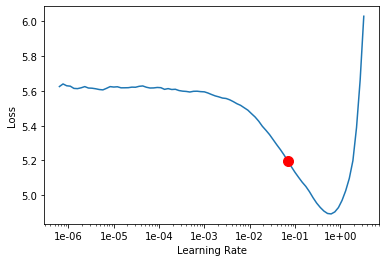

In [49]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [50]:
learn.fit_one_cycle(10,7e-02)

epoch,train_loss,valid_loss,accuracy,time
0,5.293334,4.436305,0.214509,00:01
1,4.741201,3.936543,0.245201,00:01
2,4.282844,3.966675,0.245313,00:01
3,3.915959,4.075335,0.242857,00:01
4,3.599623,4.145124,0.244196,00:01
5,3.319889,4.233636,0.245982,00:01
6,3.075160,4.269365,0.240067,00:01
7,2.856016,4.291186,0.243638,00:01
8,2.678400,4.302817,0.244754,00:01
9,2.536370,4.300717,0.245312,00:01


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 8.32E-03


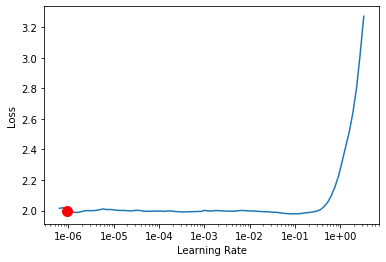

In [51]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [52]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.997338,4.301846,0.245759,00:01
1,1.988082,4.300041,0.245982,00:01
2,1.998361,4.306029,0.244308,00:01
3,1.989481,4.312794,0.244978,00:01
4,1.992635,4.306897,0.244866,00:01


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 4.37E-02


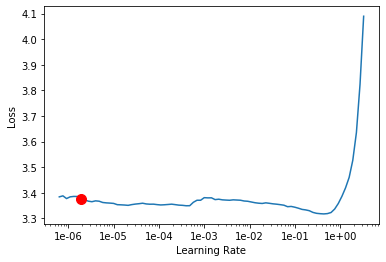

In [13]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [35]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.621408,5.391630,0.218378,00:02
1,1.612528,5.392206,0.217634,00:02
2,1.606491,5.396402,0.217857,00:02
3,1.593095,5.402508,0.218155,00:02
4,1.586157,5.412788,0.218824,00:02
5,1.575366,5.426936,0.217113,00:02
6,1.562498,5.431976,0.217708,00:02
7,1.552045,5.430505,0.218452,00:02
8,1.546920,5.427715,0.218229,00:02
9,1.553147,5.429173,0.218527,00:02


In [53]:
learn.save_encoder(path_nn_model+'/ml_encoder15k')

In [54]:
learn.save('la-model15k')

In [55]:
learn = ftxt.text_classifier_learner(data_clas, ftxt.AWD_LSTM, drop_mult=0.5)

In [56]:
learn.load_encoder(path_nn_model+'/ml_encoder15k')
learn.metrics=[ftxt.accuracy, ftxt.FBeta(average='micro')]

In [57]:
learn.save('learner-1stage')

In [58]:
learn.load('learner-1stage');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 2.09E-02


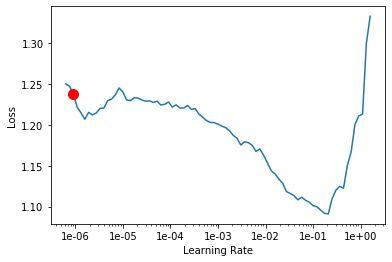

In [59]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [60]:
learn.fit_one_cycle(10,9e-07,moms=(0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.225172,1.141513,0.302961,0.302961,00:01
1,1.228145,1.229643,0.291572,0.291572,00:01
2,1.215168,1.230256,0.298405,0.298405,00:01
3,1.224488,1.242817,0.284738,0.284738,00:01
4,1.228305,1.244573,0.291572,0.291572,00:01
5,1.218399,1.225730,0.282460,0.282460,00:01
6,1.220647,1.235046,0.282460,0.282460,00:01
7,1.222668,1.232826,0.293850,0.293850,00:01
8,1.218982,1.221627,0.277904,0.277904,00:01
9,1.221031,1.228598,0.284738,0.284738,00:01


In [61]:
learn.save('learner-2stage')

In [62]:
learn.load('learner-2stage');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.00E-02


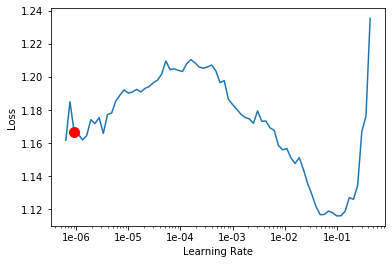

In [63]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [64]:
learn.fit_one_cycle(10,1.6e-06,moms=(0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.248611,1.233708,0.291572,0.291572,00:01
1,1.217499,1.226230,0.296128,0.296128,00:01
2,1.214894,1.217473,0.296128,0.296128,00:01
3,1.213827,1.230415,0.291572,0.291572,00:01
4,1.207336,1.228402,0.282460,0.282460,00:01
5,1.205435,1.206712,0.287016,0.287016,00:01
6,1.222689,1.219981,0.293850,0.293850,00:01
7,1.225906,1.214689,0.293850,0.293850,00:01
8,1.215484,1.202082,0.284738,0.284738,00:01
9,1.213069,1.215546,0.305239,0.305239,00:01


In [65]:
learn.save('learner-stage')

In [66]:
learn.load('learner-stage');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02
Min loss divided by 10: 1.45E-02


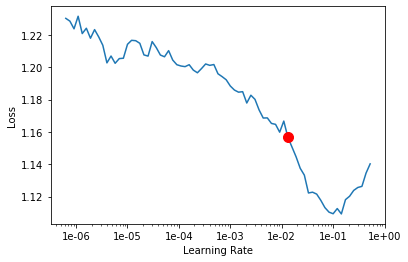

In [67]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [68]:
learn.fit_one_cycle(10,1.33e-02,moms=(0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.102732,0.950638,0.574032,0.574032,00:01
1,1.011109,0.932872,0.580866,0.580866,00:01
2,0.945762,0.962586,0.533030,0.533030,00:01
3,0.902045,0.965479,0.519362,0.519362,00:01
4,0.872919,0.973039,0.571754,0.571754,00:01
5,0.832936,0.995500,0.533030,0.533030,00:01
6,0.802334,0.959770,0.560364,0.560364,00:01
7,0.739103,0.976217,0.544419,0.544419,00:01
8,0.729016,0.968782,0.555809,0.555809,00:01
9,0.704164,0.967218,0.553531,0.553531,00:01


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 2.75E-07


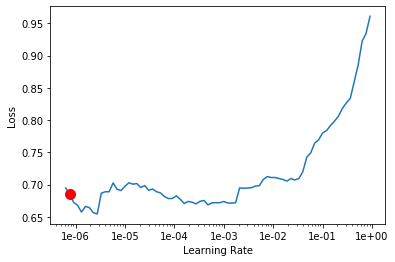

In [69]:
learn.freeze_to(-2)
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [70]:
learn.fit_one_cycle(10,7.6e-07, moms=(0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.659440,0.977907,0.551253,0.551253,00:02
1,0.665955,0.977202,0.551253,0.551253,00:02
2,0.647761,0.981975,0.564920,0.564920,00:01
3,0.661988,0.974976,0.553531,0.553531,00:02
4,0.666697,0.979929,0.564920,0.564920,00:02
5,0.670348,0.974263,0.560364,0.560364,00:02
6,0.674440,0.978068,0.560364,0.560364,00:02
7,0.688725,0.986162,0.567198,0.567198,00:02
8,0.677571,0.986367,0.558087,0.558087,00:02
9,0.660140,0.989291,0.553531,0.553531,00:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.09E-04


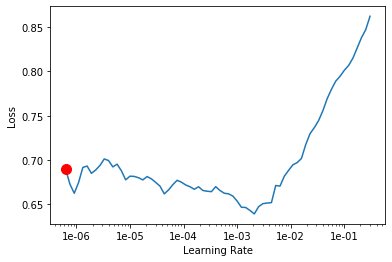

In [71]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [72]:
learn.fit_one_cycle(10,6.3e-07,moms=(0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.678827,0.978163,0.555809,0.555809,00:02
1,0.671017,0.975485,0.555809,0.555809,00:02
2,0.667159,0.981175,0.560364,0.560364,00:02
3,0.669937,0.976288,0.544419,0.544419,00:02
4,0.675329,0.973673,0.553531,0.553531,00:02
5,0.682597,0.969914,0.560364,0.560364,00:02
6,0.665315,0.964594,0.553531,0.553531,00:01
7,0.651937,0.967110,0.548975,0.548975,00:02
8,0.646411,0.984628,0.567198,0.567198,00:02
9,0.653132,0.980083,0.553531,0.553531,00:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-06
Min loss divided by 10: 1.32E-05


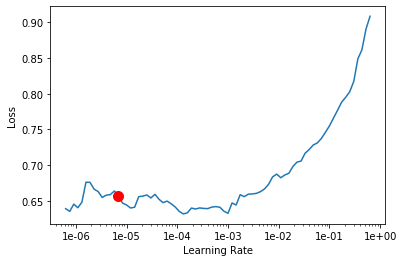

In [73]:
learn.freeze_to(-3)
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [74]:
learn.fit_one_cycle(10,moms=(0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.663961,0.980436,0.553531,0.553531,00:03
1,0.679025,0.973292,0.592255,0.592255,00:03
2,0.658240,0.920551,0.596811,0.596811,00:02
3,0.617844,0.993699,0.564920,0.564920,00:03
4,0.565995,0.959900,0.601367,0.601367,00:02
5,0.516122,1.004574,0.610478,0.610478,00:03
6,0.455957,1.000820,0.603645,0.603645,00:03
7,0.400214,1.006711,0.608200,0.608200,00:03
8,0.363186,0.992885,0.594533,0.594533,00:03
9,0.343772,1.001349,0.596811,0.596811,00:03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 5.25E-06


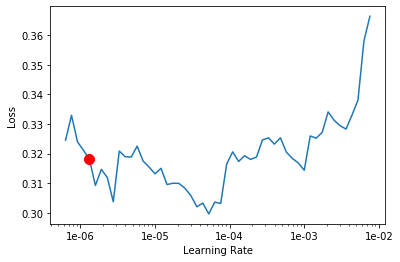

In [75]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [76]:
learn.fit_one_cycle(6,2.2e-06,moms=(0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.311811,1.002623,0.608200,0.608200,00:03
1,0.317197,0.987045,0.605923,0.605923,00:02
2,0.310058,0.999845,0.599089,0.599089,00:03
3,0.301756,0.996986,0.587699,0.587699,00:02
4,0.310693,0.999939,0.599089,0.599089,00:03
5,0.310153,1.001253,0.599089,0.599089,00:03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-05
Min loss divided by 10: 4.37E-06


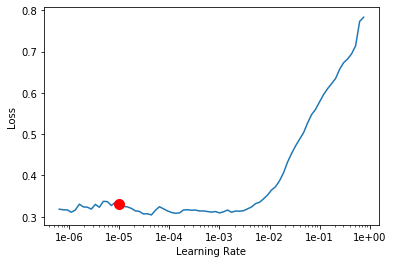

In [77]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [78]:
learn.fit_one_cycle(5, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.294830,1.038821,0.596811,0.596811,00:03
1,0.317251,1.065531,0.635535,0.635535,00:03
2,0.298831,1.060367,0.626424,0.626424,00:03
3,0.251139,1.023255,0.658314,0.658314,00:03
4,0.220613,1.034081,0.642369,0.642369,00:03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.32E-05


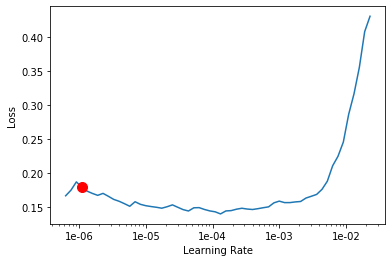

In [79]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [80]:
learn.fit_one_cycle(5,moms=(0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.184806,1.036334,0.633257,0.633257,00:03
1,0.184956,1.062510,0.644647,0.644647,00:03
2,0.171150,1.137857,0.656036,0.656036,00:03
3,0.148040,1.106666,0.644647,0.644647,00:03
4,0.124854,1.095177,0.646925,0.646925,00:03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


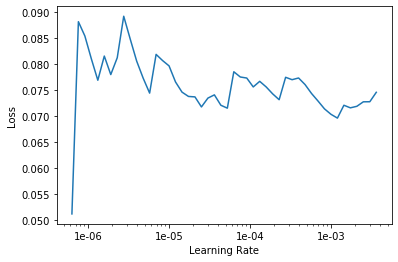

In [61]:
learn.lr_find(); learn.recorder.plot()

In [62]:
learn.fit_one_cycle(15,moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.073561,1.181819,0.626667,0.626667,00:04
1,0.086489,1.208847,0.640000,0.640000,00:04
2,0.076092,1.212426,0.620000,0.620000,00:01
3,0.076359,1.267633,0.613333,0.613333,00:01
4,0.077932,1.316755,0.593333,0.593333,00:01
5,0.074365,1.414496,0.600000,0.600000,00:01
6,0.072296,1.534045,0.593333,0.593333,00:01
7,0.069676,1.517587,0.573333,0.573333,00:01
8,0.070126,1.531858,0.586667,0.586667,00:01
9,0.069747,1.518744,0.586667,0.586667,00:01


In [47]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = ftxt.TextClassificationInterpretation(learn, preds, y, losses)

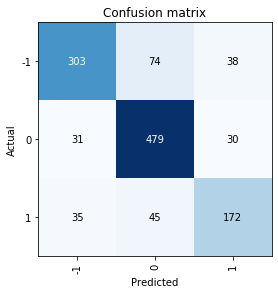

In [48]:
interp.plot_confusion_matrix()